Fetching stock data...


[*********************100%%**********************]  1 of 1 completed



Finding optimal ARIMA parameters...
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=2886.638, Time=0.80 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=2887.831, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=2884.747, Time=0.34 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=2884.957, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=2886.840, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=2885.852, Time=0.11 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=2885.609, Time=0.61 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=2885.898, Time=0.96 sec
 ARIMA(1,1,0)(0,0,1)[7] intercept   : AIC=2885.005, Time=0.36 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=2887.588, Time=1.75 sec
 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=2885.744, Time=0.18 sec
 ARIMA(2,1,0)(1,0,0)[7] intercept   : AIC=2886.716, Time=0.39 sec
 ARIMA(1,1,1)(1,0,0)[7] intercept   : AIC=2886.562, Time=0.66 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=2884.698, Time=0.25 

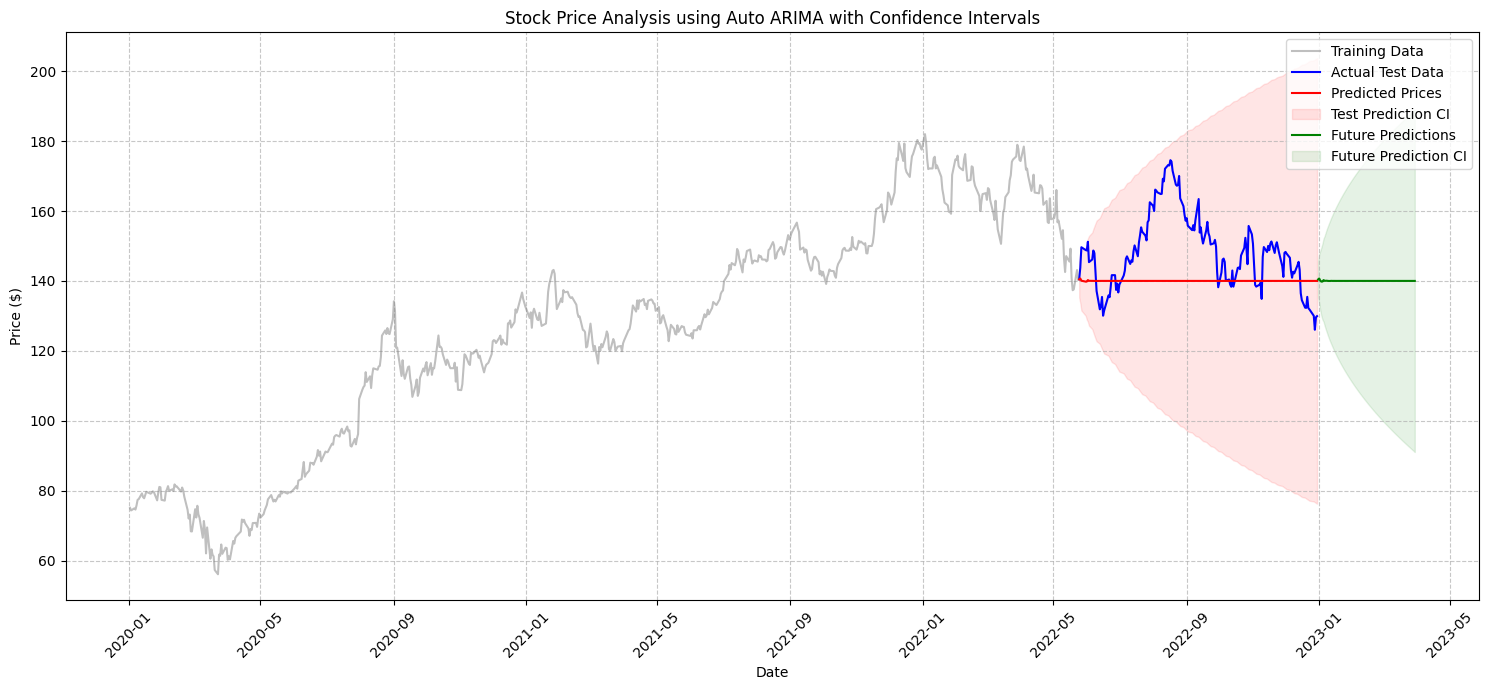


Sample of future predictions with 95% confidence intervals:


KeyError: 2

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Step 1: Fetch data from Yahoo Finance
def fetch_stock_data(ticker, start_date, end_date):
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    return stock_data

# Step 2: Prepare the data for Auto ARIMA
def prepare_data(data):
    prices = data['Close']
    train_size = int(len(prices) * 0.8)
    train = prices[:train_size]
    test = prices[train_size:]
    return train, test

# Step 3: Train Auto ARIMA model
def train_auto_arima_model(train_data):
    model = auto_arima(train_data,
                      start_p=0, start_q=0,
                      max_p=5, max_q=5,
                      m=7,  # Monthly seasonal pattern
                      d=1,  # Difference order
                      seasonal=True,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)
    
    print(f"\nBest ARIMA model parameters:")
    print(f"ARIMA order (p,d,q): {model.order}")
    print(f"Seasonal order (P,D,Q,s): {model.seasonal_order}")
    return model

# Step 4: Make predictions with confidence intervals
def make_predictions(model, n_periods, alpha=0.05):
    predictions, conf_int = model.predict(n_periods=n_periods, return_conf_int=True, alpha=alpha)
    return predictions, conf_int

# Step 5: Predict future prices with confidence intervals
def predict_future_prices(model, last_date, days=90, alpha=0.05):
    future_dates = [last_date + timedelta(days=i) for i in range(1, days + 1)]
    forecast, conf_int = model.predict(n_periods=days, return_conf_int=True, alpha=alpha)
    return future_dates, forecast, conf_int

# Step 6: Evaluate model performance
def evaluate_model(actual, predictions):
    mse = mean_squared_error(actual, predictions)
    mae = mean_absolute_error(actual, predictions)
    rmse = np.sqrt(mse)
    print(f"\nModel Performance Metrics:")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

def plot_combined_results(train_data, test_data, test_predictions, test_conf_int, 
                         future_dates, future_prices, future_conf_int):
    plt.figure(figsize=(15, 7))
    
    # Plot training data
    plt.plot(train_data.index, train_data, label='Training Data', color='gray', alpha=0.5)
    
    # Plot test data and predictions with confidence intervals
    plt.plot(test_data.index, test_data, label='Actual Test Data', color='blue')
    plt.plot(test_data.index, test_predictions, label='Predicted Prices', color='red')
    plt.fill_between(test_data.index, 
                     test_conf_int[:, 0], 
                     test_conf_int[:, 1], 
                     color='red', 
                     alpha=0.1, 
                     label='Test Prediction CI')
    
    # Plot future predictions with confidence intervals
    plt.plot(future_dates, future_prices, label='Future Predictions', color='green')
    plt.fill_between(future_dates, 
                     future_conf_int[:, 0], 
                     future_conf_int[:, 1], 
                     color='green', 
                     alpha=0.1, 
                     label='Future Prediction CI')
    
    plt.legend()
    plt.title('Stock Price Analysis using Auto ARIMA with Confidence Intervals')
    plt.xlabel('Date')
    plt.ylabel('Price ($)')
    
    # Rotate x-axis labels
    plt.xticks(rotation=45)
    
    # Add grid
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

# Example usage
if __name__ == "__main__":
    ticker = 'AAPL'
    start_date = '2020-01-01'
    end_date = '2023-01-01'
    
    # Fetch and prepare data
    print("Fetching stock data...")
    stock_data = fetch_stock_data(ticker, start_date, end_date)
    train_data, test_data = prepare_data(stock_data)
    
    # Train model
    print("\nFinding optimal ARIMA parameters...")
    model = train_auto_arima_model(train_data)
    
    # Make predictions for test period with confidence intervals
    print("\nMaking predictions...")
    test_predictions, test_conf_int = make_predictions(model, len(test_data))
    
    # Evaluate model
    evaluate_model(test_data, test_predictions)
    
    # Predict future prices with confidence intervals
    print("\nPredicting future prices...")
    last_date = stock_data.index[-1].to_pydatetime().replace(tzinfo=None)
    future_dates, future_prices, future_conf_int = predict_future_prices(model, last_date, days=90)
    
    # Plot results
    plot_combined_results(train_data, test_data, test_predictions, test_conf_int,
                         future_dates, future_prices, future_conf_int)
    
    # Print sample of future predictions with confidence intervals
    print("\nSample of future predictions with 95% confidence intervals:")
    for i in range(2, 6):
        date = future_dates[i]
        price = future_prices[i]
        lower_ci = future_conf_int[i, 0]
        upper_ci = future_conf_int[i, 1]
        print(f"{date.strftime('%Y-%m-%d')}: ${price:.2f} (95% CI: ${lower_ci:.2f} - ${upper_ci:.2f})")
    
    print(f"\nFinal prediction for {future_dates[-1].strftime('%Y-%m-%d')}:")
    print(f"Price: ${future_prices[-1]:.2f}")
    print(f"95% Confidence Interval: ${future_conf_int[-1, 0]:.2f} - ${future_conf_int[-1, 1]:.2f}")